In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import os
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../attgcn_preprocessor')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from attgcn_api import ATTGCN_API
import numpy as np
import matplotlib.pyplot as plt
from py_utils.TSP_loader import TSP_loader
from py_utils.TSP_utils import TSP_plotter

In [4]:
import re
# load heatmaps and graphs
# combine both into graphic
# add tsp plotter function
def load_heatmaps(path, start_index, end_index):
    atoi = lambda text : int(text) if text.isdigit() else text
    natural_keys = lambda text : [atoi(c) for c in re.split('(\d+)', text)]
    try:
        fnames = [f for f in os.listdir(path) if os.path.isfile(f'{path}/{f}')]
        fnames.sort(key=natural_keys)
    except:
        print('\nBad heatmap directory!')
        return None
    if len(fnames) == 1:
        return np.load(f'{path}/{fnames[0]}')
    heat_maps = None
    for k, fname in enumerate(fnames):
        maps_start_index = int(fname.split('.')[0].split('-')[0].split('_')[-1])
        maps_end_index = int(fname.split('.')[0].split('-')[-1])
        index_diff = maps_end_index - maps_start_index
        if maps_end_index - 1 < start_index :
            continue
        if maps_start_index > end_index:
            continue
        cur_start_index = start_index - maps_start_index
        cur_end_index = np.minimum(index_diff, end_index - maps_start_index)

        if heat_maps is not None:
            heat_maps = np.concatenate([heat_maps, np.load(f'{path}/{fname}')[cur_start_index:cur_end_index]], axis=0)
        else:
            heat_maps = np.load(f'{path}/{fname}')[cur_start_index:cur_end_index]
    return heat_maps

In [5]:
def load_tsp_solution(sol_filepath):
    solutions = []
    for line in open(sol_filepath):
        solution = line.split(':')[-1].strip(' ').strip('\n').strip('[]')
        solution.replace(' ', '')
        solution = [int(node) for node in solution.split(',')]
        solutions.append(solution)
    return solutions

In [6]:
def prepare_heatmap(raw_heatmap):
    heat_map = np.maximum(raw_heatmap, raw_heatmap.transpose())
    np.fill_diagonal(heat_map, 0)
    heat_map[heat_map < 10**(-10)] = 0.0
    return heat_map

In [24]:
def get_heatmap_statistics(heatmap, solution):
    heatmap = prepare_heatmap(heatmap)
    probable_edgelist = np.transpose(np.where(np.triu(heatmap) > 0))
    # probable_edgelist = np.transpose(np.array(np.where(np.tril(heatmap) > 10**(-10))))
    probable_edgelist = [list(edge) for edge in probable_edgelist]
    probable_edge_score = np.sum(heatmap) / 2
    tour_edges = list(zip(solution, solution[1:]))
    tour_edges.append((solution[-1], solution[0]))
    present_edges = 0
    tour_edge_score = 0
    for edge in tour_edges:
        if list(edge) in probable_edgelist or list(edge)[::-1] in probable_edgelist:
            present_edges += 1
            tour_edge_score += heatmap[edge[0],edge[1]]
        else:
            pass
    probable_edge_ratio = present_edges/len(tour_edges)
    num_probable_edges = len(probable_edgelist)
    return probable_edge_ratio, num_probable_edges, tour_edge_score, probable_edge_score

In [13]:
NUM_NODES = 10
n_graphs = 1000
path = f'../data/test_sets'
folder = f'synthetic_n_{NUM_NODES}_{n_graphs}'
path = f'{path}/{folder}'
heatmap_path = f'{path}/heatmaps'
# folder = f'synthetic_nrange_{NUM_NODES}_{NUM_NODES}_{n_graphs}'
folder = f'synthetic_n_{NUM_NODES}_{n_graphs}'
start_index = 0
end_index = 10000

In [ ]:
path = 'data/train_sets/synthetic_n_20_50000'
heatmap_path = f'{path}/heatmaps'
start_index = 0
end_index = 10000

In [ ]:
path = 'data/valid_sets/synthetic_n_20_1000'
heatmap_path = f'{path}/heatmaps'
start_index = 0
end_index = 10000

In [ ]:
path = 'data/test_sets/synthetic_n_50_1000'
heatmap_path = f'{path}/heatmaps'
start_index = 0
end_index = 10000

In [16]:
heat_maps = load_heatmaps(heatmap_path, start_index, end_index)
tsp_loader = TSP_loader()
g_list = tsp_loader.load_multi_tsp_as_nx(data_dir=f'{path}', scale_factor=0.000001, start_index=start_index, end_index=end_index)

100%|██████████| 1000/1000 [00:01<00:00, 542.21it/s]


In [17]:
all_solutions = load_tsp_solution(sol_filepath=f'{path}/solutions.txt')
len(all_solutions)
end_index = np.minimum(len(all_solutions), end_index)

In [18]:
num_probable_edges = []
edge_presence_rates = []
num_probable_edges_ = []
for i in range(end_index):
    heat_map = prepare_heatmap(heat_maps[i])
    probable_edgelist = np.transpose(np.where(np.triu(heat_map) > 0))
    # probable_edgelist = np.transpose(np.array(np.where(np.tril(heat_map) > 10**(-10))))
    probable_edgelist = [list(edge) for edge in probable_edgelist]
    solution = all_solutions[i]
    tour_edges = list(zip(solution, solution[1:]))
    tour_edges.append((solution[-1], solution[0]))
    present_edges = 0
    for edge in tour_edges:
        if list(edge) in probable_edgelist:
            present_edges += 1
        elif list(edge)[::-1] in probable_edgelist:
            present_edges += 1
        else:
            # print(edge)
            # print(probable_edgelist)
            pass
    edge_presence_rates.append(present_edges/len(tour_edges))
    num_probable_edges.append(len(probable_edgelist))
    num_probable_edges_.append(np.count_nonzero(heat_map)/2)


In [19]:
print("Percentage of contained optimal edges:", np.mean(edge_presence_rates))
print("Mean number of probable edges per graph:", np.mean(num_probable_edges))
print("Mean number of probable edges per graph:", np.mean(num_probable_edges_))
print("Max number of probable edges:", np.max(num_probable_edges))
print("Min number of probable edges", np.min(num_probable_edges))

Percentage of contained optimal edges: 0.7341
Mean number of probable edges per graph: 9.688
Mean number of probable edges per graph: 10.745
Max number of probable edges: 20
Min number of probable edges 3


[0, 9, 8, 6, 5, 7, 4, 3, 2, 1]


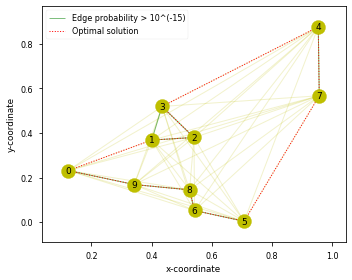

In [25]:
index = 5
heat_map = prepare_heatmap(heat_maps[index])
solution = all_solutions[index]
print(solution)
tsp_plotter = TSP_plotter()
tsp_plotter.plot_nx_graph(g_list[index], solution=solution, edge_probs=heat_map, save_path='../plots/edge_probability_10_nodes.png')